<!-- PROJECT LOGO -->
<br />
<div align="center">
  <a>
    <img src="https://res.cloudinary.com/dek4evg4t/image/upload/v1729273000/Group_4.png" alt="Logo" width="30%">
  </a>
</div>

### 🖹 Descripción:
Este Proyecto tiene como objetivo aplicar redes neuronales convolucionales (CNN) para realizar una clasificación multiclase de imágenes mediante aprendizaje supervisado. Utilizando el [Covid-19 Image Dataset de Kaggle](https://www.kaggle.com/datasets/pranavraikokte/covid19-image-dataset), que contiene imágenes de rayos X clasificadas en tres categorías (Covid-19, Normal, Neumonía), en este proyecto se desarrollarán clasificadores capaces de diagnosticar enfermedades pulmonares. El proyecto también explora el uso de PyTorch para el desarrollo de modelos de Machine Learning y herramientas de monitoreo, como Weights and Biases, para el seguimiento en tiempo real del proceso de entrenamiento.

### ✍️ Autores:
* Angelo Ortiz Vega - [@angelortizv](https://github.com/angelortizv)
* Alejandro Campos Abarca - [@MajinLoop](https://github.com/MajinLoop)

### 📅 Fecha:
20 de octubre de 2024

### 📝 Notas:
Este es el segundo proyecto del curso IC6200 - Inteligencia Artificial. En este notebook, titulado "Covid-19 Classification", se profundiza en técnicas de data augmentation, preprocesamiento de imágenes con filtros, y fine-tuning de modelos CNN como VGG16 para mejorar la capacidad de generalización de las redes neuronales convolucionales.

### Otras notas:
Asegurarse de contar con Python y las siguientes bibliotecas instaladas: torch, torchvision, cv2, numpy, matplotlib, Pillow.

# 1. Configuración

## 1.1 Importación de Librerías

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Subset, DataLoader, ConcatDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from torchviz import make_dot
os.environ["PATH"] += r";C:\Program Files\Graphviz\bin"

import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import wandb

from pathlib import Path
import os

## 1.2 Verificar PyThorch y CUDA

In [2]:
print("CUDA available:", torch.cuda.is_available())
if(torch.cuda.is_available()):
    print("CUDA version:", torch.version.cuda)
    print("Number of GPUs:", torch.cuda.device_count())
    print("Current GPU:", torch.cuda.current_device())

CUDA available: True
CUDA version: 11.8
Number of GPUs: 1
Current GPU: 0


## 1.3 Definición de Constantes

In [3]:
SEED_VALUE = 153
IMAGE_RESIZE = 128
IMAGE_NORMALIZE = 0.5

HYPERPARAMETERS = \
{
    "learning_rate": 0.001,
    "epochs": 20,
    "batch_size": 32,
    "dropout_rate": 0.5,
}

# Paths
TRAIN_DATA_PATH = 'data/Covid19-dataset/train'
TEST_DATA_PATH = 'data/Covid19-dataset/test'
VISUALIZATION_DIR = 'visualization'
MODEL_B_GRAPHS_DIR = 'Model_B_graphs'

## 1.4 Configuración de librerías

In [4]:
# PyTorch settings
torch.manual_seed(SEED_VALUE)

# Configuración de Weights & Biases
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: alejandro-campos (alejandro-campos-technological-institute-of-costa-rica). Use `wandb login --relogin` to force relogin


True

## 1.5 Definición de filtros

In [5]:
def gausian_blur(img, order=21, sigma=21):
    np_img = np.array(img)
    filtered_img = cv2.GaussianBlur(np_img, (order,order), sigma)
    return Image.fromarray(filtered_img)

def bilateral_filter(img):
    """
    d: Diameter of each pixel neighborhood.
    
    sigmaColor: Value of \sigma in the color space. The greater the value, the colors farther to each other will start to get mixed.
    
    sigmaSpace: Value of \sigma in the coordinate space. The greater its value, the more further pixels will mix together, given that
    their colors lie within the sigmaColor range.    
    """
    np_img = np.array(img)
    filtered_img = cv2.bilateralFilter(np_img, 15, 75, 75)
    return Image.fromarray(filtered_img) 

def canny_edge_filter(img, min_val=40, max_val=85):
    img = np.array(img)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) # PIL (RGB) -> OpenCV (BGR)
    img = cv2.Canny(img, min_val, max_val)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # OpenCV (BGR) -> PIL (RGB)
    return Image.fromarray(img)

## 1.6 Creación de los dataframes

### 1.6.1 Transforms

In [6]:
transform_r = transforms.Compose \
(
    [
        transforms.Resize((IMAGE_RESIZE, IMAGE_RESIZE)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((IMAGE_NORMALIZE,), (IMAGE_NORMALIZE,))
    ]
)
transform_r_augmented = transforms.Compose \
(
    [
        transforms.Resize((IMAGE_RESIZE, IMAGE_RESIZE)),
        
        transforms.RandomHorizontalFlip(),                          # Volteo horizontal aleatorio
        transforms.RandomRotation(30),                              # Rotación aleatoria de hasta 30 grados
        transforms.RandomAffine(degrees=30, translate=(0.1, 0.1)),  # Desplazamiento aleatorio con rotación
        
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((IMAGE_NORMALIZE,), (IMAGE_NORMALIZE,))
    ]
)

transform_b = transforms.Compose \
(
    [
        transforms.Resize((IMAGE_RESIZE, IMAGE_RESIZE)),
        transforms.Lambda(lambda img: bilateral_filter(img)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((IMAGE_NORMALIZE,), (IMAGE_NORMALIZE,))
    ]
)
transform_b_augmented = transforms.Compose \
(
    [
        transforms.Resize((IMAGE_RESIZE, IMAGE_RESIZE)),

        transforms.RandomHorizontalFlip(),                          # Volteo horizontal aleatorio
        transforms.RandomRotation(30),                              # Rotación aleatoria de hasta 30 grados
        transforms.RandomAffine(degrees=30, translate=(0.1, 0.1)),  # Desplazamiento aleatorio con rotación

        transforms.Lambda(lambda img: bilateral_filter(img)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((IMAGE_NORMALIZE,), (IMAGE_NORMALIZE,))
    ]
)

transform_c = transforms.Compose \
(
    [
        transforms.Resize((IMAGE_RESIZE, IMAGE_RESIZE)),
        transforms.Lambda(lambda img: canny_edge_filter(img)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((IMAGE_NORMALIZE,), (IMAGE_NORMALIZE,))
    ]
)
transform_c_augmented = transforms.Compose \
(
    [
        transforms.Resize((IMAGE_RESIZE, IMAGE_RESIZE)),

        transforms.RandomHorizontalFlip(),                          # Volteo horizontal aleatorio
        transforms.RandomRotation(30),                              # Rotación aleatoria de hasta 30 grados
        transforms.RandomAffine(degrees=30, translate=(0.1, 0.1)),  # Desplazamiento aleatorio con rotación

        transforms.Lambda(lambda img: canny_edge_filter(img)),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((IMAGE_NORMALIZE,), (IMAGE_NORMALIZE,))
    ]
)

### 1.6.2 Dataloaders

In [7]:
def get_sub_data_loader(dataset, fraction_of_data=0.1):
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    subset_size = int(np.floor(fraction_of_data * dataset_size))
    np.random.shuffle(indices)
    subset_indices = indices[:subset_size]
    sub_dataset = Subset(dataset, subset_indices)
    # print(f'Subset size: {len(sub_dataset)}')
    return DataLoader(dataset=sub_dataset, batch_size=HYPERPARAMETERS["batch_size"], shuffle=True)
#-----------------------------------------------------------------------------------------------------------------------------


# Train data
# Raw
train_dataset_r = datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=transform_r)
train_dataset_r_augmented = datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=transform_r_augmented)
combined_train_dataset_r = ConcatDataset([train_dataset_r, train_dataset_r_augmented])
train_loader_r = DataLoader(dataset=combined_train_dataset_r, batch_size=HYPERPARAMETERS["batch_size"], shuffle=True)
train_sub_loader_r = get_sub_data_loader(dataset=combined_train_dataset_r)

# Bilateral
train_dataset_b = datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=transform_b_augmented)
train_dataset_b_augmented = datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=transform_b_augmented)
combined_train_dataset_b = ConcatDataset([train_dataset_b, train_dataset_b_augmented])
train_loader_b = DataLoader(dataset=combined_train_dataset_b, batch_size=HYPERPARAMETERS["batch_size"], shuffle=True)
train_sub_loader_b = get_sub_data_loader(dataset=combined_train_dataset_b)

# Canny
train_dataset_c = datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=transform_c_augmented)
train_dataset_c_augmented = datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=transform_c_augmented)
combined_train_dataset_c = ConcatDataset([train_dataset_c, train_dataset_c_augmented])
train_loader_c = DataLoader(dataset=combined_train_dataset_c, batch_size=HYPERPARAMETERS["batch_size"], shuffle=True)
train_sub_loader_c = get_sub_data_loader(dataset=combined_train_dataset_c)
#-----------------------------------------------------------------------------------------------------------------------------

# Test data
# Raw
test_dataset_r = datasets.ImageFolder(root=TEST_DATA_PATH, transform=transform_r_augmented)
test_loader_r = DataLoader(dataset=test_dataset_r, batch_size=HYPERPARAMETERS["batch_size"], shuffle=True)
# Bilateral
test_dataset_b = datasets.ImageFolder(root=TEST_DATA_PATH, transform=transform_b_augmented)
test_loader_b = DataLoader(dataset=test_dataset_b, batch_size=HYPERPARAMETERS["batch_size"], shuffle=True)
# Canny
test_dataset_c = datasets.ImageFolder(root=TEST_DATA_PATH, transform=transform_c_augmented)
test_loader_c = DataLoader(dataset=test_dataset_c, batch_size=HYPERPARAMETERS["batch_size"], shuffle=True)
#-----------------------------------------------------------------------------------------------------------------------------


print(f'Tamaño del conjunto de entrenamiento: {len(train_loader_r.dataset)}')
print(f'Tamaño del conjunto de testing: {len(test_loader_r.dataset)}')

Tamaño del conjunto de entrenamiento: 502
Tamaño del conjunto de testing: 66


## 1.7 Visualización de los filtros

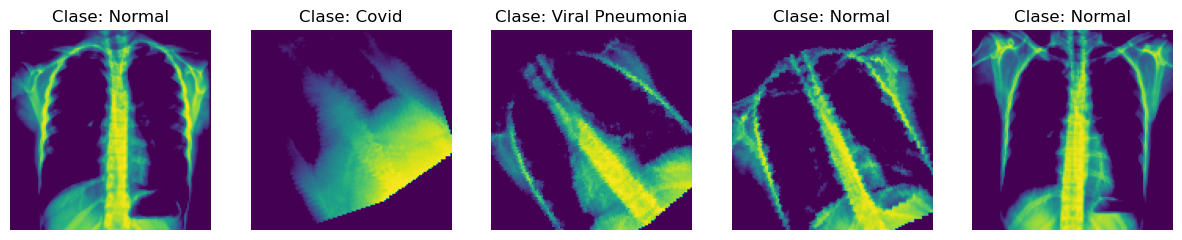

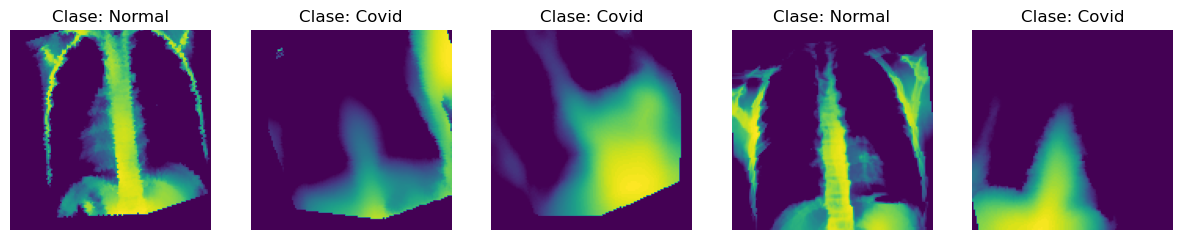

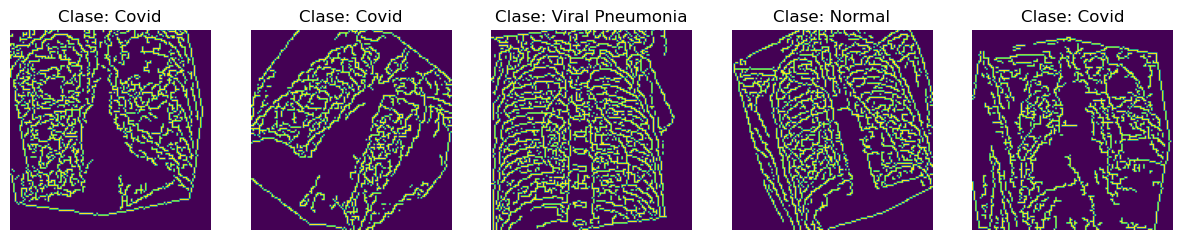

In [8]:
def show_first_five_images(data_loader, dataset):
    
    try:
        images, labels = next(iter(data_loader))
    
    except StopIteration:
        print("El DataLoader no tiene más datos.")
    
    except Exception as e:
        print(f"Ocurrió un error: {e}")
    
    images = images.numpy().transpose((0, 2, 3, 1))
    images = np.clip(images, 0, 1)

    _, axes = plt.subplots(1, 5, figsize=(15, 5))
    for ax, img, label in zip(axes, images[:5], labels[:5]):
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f'Clase: {dataset.classes[label.item()]}')
    plt.show()

show_first_five_images(train_loader_r, train_dataset_r)
show_first_five_images(train_loader_b, train_dataset_b)
show_first_five_images(train_loader_c, train_dataset_c)


Los colores se ven inusuales porque `plt` asume que la imagen está en formato RGB, pero en realidad solo tiene un canal de color. Esto se debe a que el modelo está diseñado para aceptar entradas con solo un canal de color.

## 1.8 Función de entrenamiento

In [9]:
def train(model, train_data_loader, model_name):
    criterion = nn.CrossEntropyLoss()
    initial_wandb_learning_rate = wandb.config.learning_rate # Guardar el learning rate inicial
    optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

    for epoch in range(wandb.config.epochs):

        accumulated_epoch_loss = 0
        epoch_correct_predictions = 0
        epoch_total_samples = 0

        # For batch
        for images, labels in train_data_loader:

            # Limpiar gradientes: Se restablecen los gradientes acumulados en el optimizador a cero para evitar que se sumen a los gradientes del lote actual.
            optimizer.zero_grad()

            # Forward: Se pasan las imágenes a través del modelo para obtener las predicciones (model_predictions).
            model_predictions = model(images)

            # Cálculo de la pérdida: Se calcula la pérdida utilizando la función de pérdida definida anteriormente,
            # comparando las predicciones (model_predictions) con las etiquetas verdaderas (labels).
            batch_loss = criterion(model_predictions, labels)
            
            # Sumar la pérdida de este lote a la pérdida total de la época
            accumulated_epoch_loss += batch_loss.item()

            _, predicted = torch.max(model_predictions, 1)  # Obtener las predicciones con el mayor valor (clase más probable)
            batch_correct_predictions = (predicted == labels).sum().item()    # Contar cuántas predicciones son correctas
            total_samples = labels.size(0)                          # Total de elementos en el batch

            epoch_correct_predictions += batch_correct_predictions
            epoch_total_samples += total_samples

            # Backward pass: Se realiza la propagación hacia atrás para calcular los gradientes de la pérdida con respecto a los parámetros del modelo.
            batch_loss.backward()

            # Actualizar parámetros: Se actualizan los parámetros del modelo utilizando los gradientes calculados en la etapa anterior.
            optimizer.step()

        # Cálculo de la accuracy promedio de la época
        epoch_loss = accumulated_epoch_loss / len(train_data_loader)
        epoch_accuracy = 100 * epoch_correct_predictions / epoch_total_samples

        # Imprimir pérdida promedio y accuracy por época, así como el LR
        current_lr = optimizer.param_groups[0]['lr']    # Obtener el learning rate actual
        print(f'Epoch [{epoch + 1}/{wandb.config.epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Learning Rate: {current_lr:.6f}')

        # WandB
        wandb.config.update({"learning_rate": current_lr})
        wandb.log({"epoch": epoch, "loss": epoch_loss, "accuracy": epoch_accuracy, "model": model_name}, commit=True)

        scheduler.step(epoch_loss)
    
    # Restaurar el valor inicial de learning rate después del entrenamiento
    wandb.config.update({"learning_rate": initial_wandb_learning_rate})

- **mode**='min': El scheduler se activará si la pérdida se encuentra en su mínimo.
- **factor**=0.5: Reducirá el learning rate a la mitad.
- **patience**=2: Esperará 2 épocas antes de reducir el learning rate si no hay mejora.

## 1.9 Funciones de evaluación

In [10]:
def evaluate_model(model, test_data_loader):
    correct = 0
    total = 0

    with torch.no_grad():

        for images, labels in test_data_loader:

            model_predictions = model(images)
            _, predicted = torch.max(model_predictions.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the model on the test images: {100 * correct / total:.2f}%')


def get_predictions(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return np.array(all_labels), np.array(all_preds)


def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.show()


def make_wandb_project(
        project_name: str,
        model_name: str,
        hyperparameters: dict,
        model,
        print_msg: str,
        data_loader: DataLoader,
        wandb_watch_log = "all"):
    
    wandb.init(project=project_name, name=model_name)
    wandb.config.update(hyperparameters)
    wandb.watch(model, log=wandb_watch_log)
    print(print_msg)
    train(model=model, train_data_loader=data_loader, model_name=model)
    print()
    wandb.unwatch(model)
    wandb.finish()

# 2. Modelo B

## 2.1 Arquitectura B-A1

### 2.1.1 Definición

In [11]:
class CNN1(nn.Module):
    def __init__(self):
        super(CNN1, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.inception1 = self.InceptionBlock(in_channels=32) # -> 128
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)

        self.fc1 = nn.Linear(in_features=(128 * 16 * 16), out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=3)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(HYPERPARAMETERS["dropout_rate"])

    class InceptionBlock(nn.Module):
        def __init__(self, in_channels):
            super(CNN1.InceptionBlock, self).__init__()
            self.branch1x1 = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=1)

            self.branch3x3_1 = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=1)
            self.branch3x3_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)

            self.branch5x5_1 = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=1)
            self.branch5x5_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, padding=2)

            self.branch_pool = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=1)

        def forward(self, x):
            branch1 = self.branch1x1(x)

            branch2 = self.branch3x3_1(x)
            branch2 = self.branch3x3_2(branch2)

            branch3 = self.branch5x5_1(x)
            branch3 = self.branch5x5_2(branch3)

            branch4 = F.max_pool2d(x, kernel_size=3, stride=1, padding=1)
            branch4 = self.branch_pool(branch4)

            outputs = [branch1, branch2, branch3, branch4]
            return torch.cat(outputs, 1) # (32 + 32 + 32 + 32 = 128)

    def forward(self, x):
        # Etapa 1
        x = self.pool(F.relu(self.conv1(x)))    # [32, 1, 128, 128] -conv-> [32, 32, 128, 128] -ReLu-> same -pooling-> [32, 32, 64, 64]
        x = self.pool(self.inception1(x))       # [32, 32, 64, 64] -incep-> [32, 128, 64, 64] -pooling-> [32, 128, 32, 32]
        x = self.pool(F.relu(self.conv2(x)))    # [32, 128, 32, 32] -conv-> [32, 128, 32, 32] -ReLu-> same -pooling-> [32, 128, 16, 16]
        # Etapa 2
        x = x.view(-1, 128 * 16 * 16)           # [32, 128, 16, 16] -view-> [32, 128*16*16]
        # Etapa 3
        x = F.relu(self.fc1(x))                 # [32, 128*16*16] -fc-> [32, 64]
        x = self.dropout(x)                     # Aplicar Dropout
        x = self.fc2(x)                         # [32, 64] -fc-> [32, 3]
        return x

#### Justificación de la arquitectura B-A1

La arquitectura propuesta para esta CNN está diseñada de manera que logre un equilibrio entre simplicidad y capacidad de extracción de características en imágenes. A continuación, justifico las decisiones tomadas en la estructura del modelo:

##### 1. **Capas convolucionales (Conv2D)**
Se han utilizado tres capas convolucionales con un número creciente de filtros (32, 128) y un tamaño de kernel de 3x3, junto con un bloque Inception. Esta configuración permite:
- **Extracción progresiva de características**: Al aumentar el número de canales, la red puede capturar detalles de baja a alta complejidad a medida que las imágenes pasan por las capas.
- **Receptive field**: El tamaño de 3x3 es un estándar eficaz que equilibra precisión y costo computacional, permitiendo que la red capture patrones locales en las imágenes.

##### 2. **Bloque Inception**
La incorporación de un bloque Inception permite que la red capture una variedad más amplia de características a diferentes escalas. Las ventajas incluyen:
- **Múltiples tamaños de convolución**: El bloque utiliza convoluciones con diferentes tamaños de kernel (1x1, 3x3, 5x5) en paralelo, permitiendo que la red aprenda a detectar características en diversas escalas.
- **Reducción de dimensionalidad**: Las convoluciones de 1x1 ayudan a reducir el número de canales, optimizando la carga computacional.

##### 3. **Max Pooling**
El uso de `MaxPool2D` con kernel 2x2 reduce las dimensiones espaciales de las imágenes (de 128x128 a 16x16 tras 3 pasos), permitiendo:
- **Reducción de la dimensionalidad**: Lo cual es clave para disminuir el número de parámetros en las capas completamente conectadas (fully connected), evitando el sobreajuste.
- **Retención de información importante**: El max pooling retiene los valores máximos en cada región, preservando características clave mientras descarta información redundante.

##### 4. **Capas completamente conectadas (Fully Connected)**
Se ha elegido un número moderado de neuronas en las capas `fc1` (64) y `fc2` (3), con las siguientes razones:
- **Compactación de las características**: La salida de la última capa convolucional se transforma en un vector de características mediante `view`, y las capas fully connected resumen esta información en un formato útil para la clasificación.
- **Reducción final a 3 clases**: La capa `fc2` genera una salida de 3 neuronas, correspondiente a las 3 categorías del problema.

##### 5. **Dropout**
Se introduce dropout en las últimas iteraciones con el fin de:
- **Evitar el sobreajuste**: Dropout es una técnica eficaz para mejorar la generalización del modelo, ya que previene la dependencia excesiva en ciertos patrones durante el entrenamiento.

##### 6. **Resultados experimentales**
El desempeño del modelo mejora notablemente a lo largo de las iteraciones al ajustar los hiperparámetros (learning rate, epochs) y al incluir dropout. Esto valida que la arquitectura es capaz de aprender representaciones útiles cuando se le da suficiente tiempo de entrenamiento y se aplican técnicas de regularización adecuadas.

##### 7. **Etapas**
Las **etapas** de esta red CNN se pueden dividir en tres bloques principales:

###### 1. **Etapa de extracción de características**
   - **Capas**: `conv1`, `inception1`, `conv2`, y `pool`
   - **Descripción**: Esta etapa utiliza capas convolucionales y de pooling para extraer características de la imagen de entrada. La activación `ReLU` añade no linealidad y el `MaxPool2D` reduce la dimensionalidad de los mapas de características.
     - Conv1: Extrae características iniciales de la imagen (bordes, texturas).
     - Inception1: Captura características en múltiples escalas.
     - Conv2: Extrae aún más características complejas.
     - MaxPool: Reduce la dimensión espacial después de cada convolución.

###### 2. **Etapa de aplanamiento (Flattening)**
   - **Capas**: `x.view(-1, 128 * 16 * 16)`
   - **Descripción**: Aplana la salida de la última capa convolucional en un vector para poder pasarla a las capas totalmente conectadas.

###### 3. **Etapa de clasificación**
   - **Capas**: `fc1`, `dropout`, `fc2`
   - **Descripción**: Las capas completamente conectadas (`fc1` y `fc2`) se encargan de la clasificación final. `fc1` reduce la dimensionalidad a 64 neuronas, y después se aplica un `dropout` para prevenir el sobreajuste. Finalmente, `fc2` produce la salida de 3 clases (asumiendo una clasificación de 3 categorías).

Estas tres etapas forman la estructura completa de la CNN.

##### Transformación de `x` a través de la red
El tensor de entrada `x` tiene la forma `[N, C, H, W]`, donde:
- **N** = Batch size (número de muestras).
- **C** = Número de canales.
- **H** = Altura de la entrada.
- **W** = Ancho de la entrada.

- **Input shape**: `[32, 1, 128, 128]`
1. `[32, 1, 128, 128]` → **Conv1** → `[32, 32, 128, 128]` → **ReLU** → `[32, 32, 128, 128]` → **Pooling** → `[32, 32, 64, 64]`
2. `[32, 32, 64, 64]` → **Inception1** → `[32, 128, 64, 64]` → **Pooling** → `[32, 128, 32, 32]`
3. `[32, 128, 32, 32]` → **Conv2** → `[32, 128, 32, 32]` → **ReLU** → `[32, 128, 32, 32]` → **Pooling** → `[32, 128, 16, 16]`
4. `[32, 128, 16, 16]` → **View** → `[32, 128 * 16 * 16]`
5. `[32, 128 * 16 * 16]` → **Fully Connected (fc1)** → `[32, 64]`
6. `[32, 64]` → **Fully Connected (fc2)** → `[32, 3]`

###### `x.view()` function:
La función `view()` en PyTorch se utiliza para cambiar la forma de un tensor sin alterar sus datos subyacentes.
Transforma el tensor de entrada de una forma 4D `[N, C, H, W]` a una forma 2D `[N, F]`, donde:
- **F** = Número de características (features).
El número de características se calcula como:
\[
F = C \times H \times W
\]

#### Explicación de las capas

##### Capas de Pooling
Una capa de pooling reduce la dimensionalidad del mapa de características generado por la capa de convolución. Funciona tomando un subconjunto de valores (por ejemplo, el valor máximo o promedio) dentro de una ventana deslizante, lo que disminuye el tamaño de la representación. Esto ayuda a preservar las características más importantes mientras se descartan detalles menos relevantes.
La reducción en la dimensionalidad también mejora la eficiencia computacional y ayuda a prevenir el sobreajuste. En resumen, el pooling simplifica la representación y permite que el modelo se enfoque en las características más significativas.

###### Cálculo de la Dimensionalidad:
$$
\begin{aligned}
d' = \frac{d - k}{s} + 1
\end{aligned}
$$

Parámetros:
- **d -> dimension_in**: Es el tamaño de la dimension de entrada
- **k -> kernel_size**: Es el tamaño del kernel (matriz de orden $k^2$).
- **s -> stride**: El número de píxeles que el filtro se desplaza sobre la imagen de entrada, con un valor de 1 significando que se mueve un píxel a la vez.
- **d' -> dimension_out**: Es el tamaño de la dimension de salida.

##### Capas de convolución
Una capa de convolución extrae características de la imagen de entrada mediante filtros que se deslizan sobre la misma. 
Aplica una operación matemática llamada convolución, produciendo un mapa de características que resalta patrones como bordes y texturas. 
Mantiene la estructura espacial de la imagen, permitiendo que el modelo aprenda relaciones espaciales. 
Generalmente, se le aplica una función de activación (como ReLU) para introducir no linealidades.

###### Cálculo de la Dimensionalidad:
$$
\begin{aligned}
d' = \frac{d + 2p - k}{s} + 1
\end{aligned}
$$

Parámetros:
- **k -> kernel_size**: Es el orden de una matriz cuadrada.
- **s -> stride**: El número de píxeles que el filtro se desplaza sobre la imagen de entrada, con un valor de 1 significando que se mueve un píxel a la vez.
- **p -> padding**: El número de píxeles añadidos alrededor de la imagen de entrada para mantener las dimensiones de salida. El padding ayuda a prevenir que la imagen se reduzca demasiado después de la convolución, permitiendo una mejor retención de información en los bordes.


##### Capas Fully Connected
Una capa totalmente conectada (fully connected layer) conecta cada neurona de la capa anterior a cada neurona de la capa actual. Se utiliza para combinar las características extraídas por las capas previas y realizar la clasificación o regresión. 
Cada neurona en esta capa aplica una transformación lineal a las entradas, seguida de una función de activación, lo que permite al modelo aprender patrones complejos. Las capas totalmente conectadas suelen encontrarse al final de una red neuronal, después de las capas de convolución y pooling.
En resumen, estas capas integran la información y producen la salida final del modelo.


##### Capa Dropout
La capa `Dropout` es una técnica de regularización utilizada para prevenir el sobreajuste durante el entrenamiento de redes neuronales. En cada paso de entrenamiento, desactiva aleatoriamente un porcentaje de neuronas (definido por `DROPOUT_RATE`), lo que obliga a la red a no depender demasiado de una sola neurona. Esto mejora la generalización del modelo, ayudando a que aprenda patrones más robustos. En esta CNN, se aplica después de la primera capa completamente conectada para mejorar el rendimiento en tareas de clasificación.

### 2.1.2 Creación de los modelos B-A1 (Raw, Bilateral y Canny)

In [12]:
model_b_a1_r = CNN1()  # Modelo para datos crudos
model_b_a1_b = CNN1()  # Modelo para datos con filtro bilateral
model_b_a1_c = CNN1()  # Modelo para datos con filtro Canny

### 2.1.3 Viusalización del modelo B-A1

In [13]:
x = torch.randn(1, 1, 128, 128)  # Tensor de ejemplo
y = model_b_a1_r(x)

dot = make_dot(y, params=dict(list(model_b_a1_r.named_parameters())))
dot.attr(dpi='300')
file_name = 'model_b_a1_graph'
directory = os.path.join(VISUALIZATION_DIR, MODEL_B_GRAPHS_DIR)
dot.render(filename=file_name, directory=directory, format='png')

'visualization\\Model_B_graphs\\model_b_a1_graph.png'

### 2.1.4 Entrenamiento de modelos B-A1

In [14]:
make_wandb_project(project_name="project_b_a1_r", model_name="model_b_a1_r", hyperparameters=HYPERPARAMETERS,
                   model=model_b_a1_r, print_msg="Training model B-A1 Raw", data_loader=train_sub_loader_r)

make_wandb_project(project_name="project_b_a1_b", model_name="model_b_a1_b", hyperparameters=HYPERPARAMETERS,
                   model=model_b_a1_b, print_msg="Training model B-A1 Bilateral", data_loader=train_sub_loader_b)

make_wandb_project(project_name="project_b_a1_c", model_name="model_b_a1_c", hyperparameters=HYPERPARAMETERS,
                   model=model_b_a1_c, print_msg="Training model B-A1 Canny", data_loader=train_sub_loader_c)

Training model B-A1 Raw


c:\Users\aleja\.conda\envs\env_IC6200_AI_P2_pytorch\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/20], Loss: 1.1247, Accuracy: 38.00%, Learning Rate: 0.001000
Epoch [2/20], Loss: 1.0499, Accuracy: 44.00%, Learning Rate: 0.001000
Epoch [3/20], Loss: 0.8872, Accuracy: 60.00%, Learning Rate: 0.001000
Epoch [4/20], Loss: 0.8309, Accuracy: 64.00%, Learning Rate: 0.001000
Epoch [5/20], Loss: 0.7480, Accuracy: 66.00%, Learning Rate: 0.001000
Epoch [6/20], Loss: 0.5155, Accuracy: 78.00%, Learning Rate: 0.001000
Epoch [7/20], Loss: 0.5606, Accuracy: 80.00%, Learning Rate: 0.001000
Epoch [8/20], Loss: 0.6242, Accuracy: 74.00%, Learning Rate: 0.001000
Epoch [9/20], Loss: 0.4405, Accuracy: 80.00%, Learning Rate: 0.001000
Epoch [10/20], Loss: 0.4031, Accuracy: 82.00%, Learning Rate: 0.001000
Epoch [11/20], Loss: 0.4386, Accuracy: 84.00%, Learning Rate: 0.001000
Epoch [12/20], Loss: 0.3796, Accuracy: 88.00%, Learning Rate: 0.001000
Epoch [13/20], Loss: 0.4431, Accuracy: 82.00%, Learning Rate: 0.001000
Epoch [14/20], Loss: 0.5437, Accuracy: 70.00%, Learning Rate: 0.001000
Epoch [15/20], 

accuracy,▁▂▄▄▅▆▆▆▆▇▇▇▇▅▆▇▆▇█▇
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▇▆▆▅▃▃▄▂▂▂▂▂▃▃▂▂▂▁▁
accuracy,88
epoch,19
loss,0.33508
model,CNN1( (conv1): Con...


Training model B-A1 Bilateral


c:\Users\aleja\.conda\envs\env_IC6200_AI_P2_pytorch\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/20], Loss: 1.4865, Accuracy: 34.00%, Learning Rate: 0.001000
Epoch [2/20], Loss: 1.0859, Accuracy: 42.00%, Learning Rate: 0.001000
Epoch [3/20], Loss: 1.0891, Accuracy: 34.00%, Learning Rate: 0.001000
Epoch [4/20], Loss: 1.0254, Accuracy: 48.00%, Learning Rate: 0.001000
Epoch [5/20], Loss: 1.0090, Accuracy: 48.00%, Learning Rate: 0.001000
Epoch [6/20], Loss: 1.0087, Accuracy: 50.00%, Learning Rate: 0.001000
Epoch [7/20], Loss: 0.9906, Accuracy: 46.00%, Learning Rate: 0.001000
Epoch [8/20], Loss: 1.0229, Accuracy: 52.00%, Learning Rate: 0.001000
Epoch [9/20], Loss: 0.9274, Accuracy: 54.00%, Learning Rate: 0.001000
Epoch [10/20], Loss: 0.9180, Accuracy: 56.00%, Learning Rate: 0.001000
Epoch [11/20], Loss: 0.8595, Accuracy: 56.00%, Learning Rate: 0.001000
Epoch [12/20], Loss: 0.7969, Accuracy: 54.00%, Learning Rate: 0.001000
Epoch [13/20], Loss: 0.9659, Accuracy: 60.00%, Learning Rate: 0.001000
Epoch [14/20], Loss: 0.6561, Accuracy: 70.00%, Learning Rate: 0.001000
Epoch [15/20], 

accuracy,▁▂▁▃▃▄▃▄▄▅▅▄▅▇▅▇█▆▅▇
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▅▅▄▄▄▄▄▃▃▃▂▄▁▂▃▁▂▂▂
accuracy,70
epoch,19
loss,0.78469
model,CNN1( (conv1): Con...


Training model B-A1 Canny


c:\Users\aleja\.conda\envs\env_IC6200_AI_P2_pytorch\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/20], Loss: 1.5621, Accuracy: 34.00%, Learning Rate: 0.001000
Epoch [2/20], Loss: 1.1671, Accuracy: 36.00%, Learning Rate: 0.001000
Epoch [3/20], Loss: 1.0003, Accuracy: 38.00%, Learning Rate: 0.001000
Epoch [4/20], Loss: 0.9044, Accuracy: 42.00%, Learning Rate: 0.001000
Epoch [5/20], Loss: 0.7774, Accuracy: 58.00%, Learning Rate: 0.001000
Epoch [6/20], Loss: 0.6633, Accuracy: 64.00%, Learning Rate: 0.001000
Epoch [7/20], Loss: 0.7857, Accuracy: 72.00%, Learning Rate: 0.001000
Epoch [8/20], Loss: 0.5177, Accuracy: 72.00%, Learning Rate: 0.001000
Epoch [9/20], Loss: 0.5811, Accuracy: 78.00%, Learning Rate: 0.001000
Epoch [10/20], Loss: 0.7306, Accuracy: 58.00%, Learning Rate: 0.001000
Epoch [11/20], Loss: 0.6944, Accuracy: 66.00%, Learning Rate: 0.001000
Epoch [12/20], Loss: 0.5333, Accuracy: 76.00%, Learning Rate: 0.000500
Epoch [13/20], Loss: 0.5447, Accuracy: 68.00%, Learning Rate: 0.000500
Epoch [14/20], Loss: 0.5809, Accuracy: 76.00%, Learning Rate: 0.000500
Epoch [15/20], 

accuracy,▁▁▂▂▅▆▇▇█▅▆▇▆▇▇███▇▇
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▅▄▄▃▂▃▁▂▃▂▁▁▂▁▁▁▁▁▁
accuracy,74
epoch,19
loss,0.52933
model,CNN1( (conv1): Con...


### 2.1.5 Evaluación de modelos B-A1

In [15]:
print("Evaluating model B-A1 Raw")
evaluate_model(model=model_b_a1_r, test_data_loader=test_loader_r)
print()

print("Evaluating model B-A1 Bilateral")
evaluate_model(model=model_b_a1_b, test_data_loader=test_loader_b)
print()

print("Evaluating model B-A1 Canny")
evaluate_model(model=model_b_a1_c, test_data_loader=test_loader_c)
print()

Evaluating model B-A1 Raw
Accuracy of the model on the test images: 62.12%

Evaluating model B-A1 Bilateral
Accuracy of the model on the test images: 51.52%

Evaluating model B-A1 Canny
Accuracy of the model on the test images: 56.06%



### 2.1.6 Matriz de confusión de los modelos B-A1

Evaluando modelo B-A1 Raw


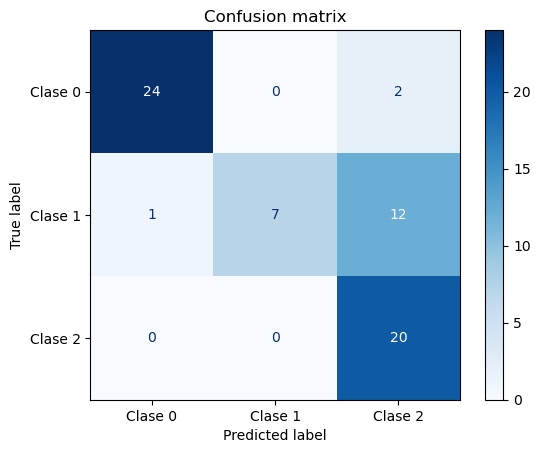

Evaluando modelo B-A1 Bilateral


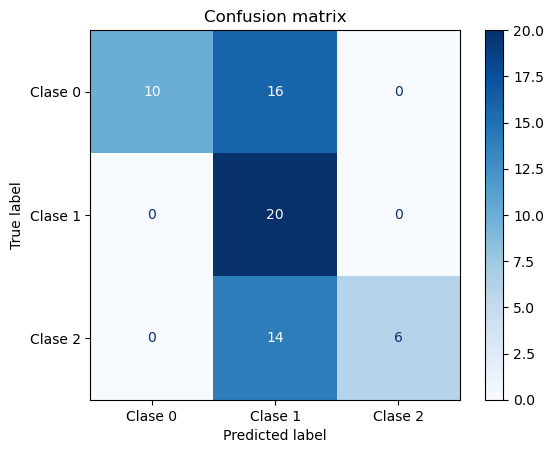

Evaluando modelo B-A1 Canny


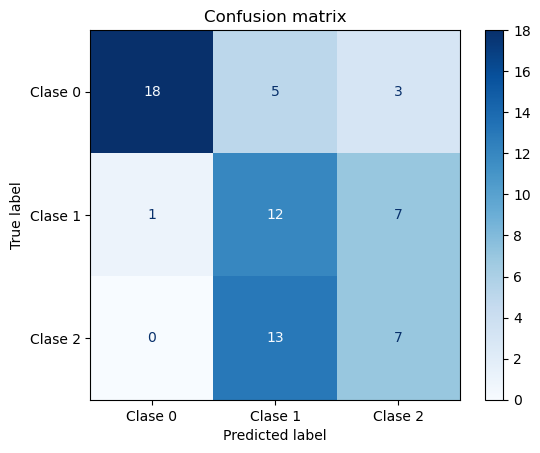

In [16]:
print("Evaluando modelo B-A1 Raw")
y_true_r, y_pred_r = get_predictions(model=model_b_a1_r, data_loader=test_loader_r)
plot_confusion_matrix(y_true_r, y_pred_r, class_names=['Clase 0', 'Clase 1', 'Clase 2'])

print("Evaluando modelo B-A1 Bilateral")
y_true_b, y_pred_b = get_predictions(model=model_b_a1_b, data_loader=test_loader_b)
plot_confusion_matrix(y_true_b, y_pred_b, class_names=['Clase 0', 'Clase 1', 'Clase 2'])

print("Evaluando modelo B-A1 Canny")
y_true_c, y_pred_c = get_predictions(model=model_b_a1_c, data_loader=test_loader_c)
plot_confusion_matrix(y_true_c, y_pred_c, class_names=['Clase 0', 'Clase 1', 'Clase 2'])

## 2.2 Arquitectura B-A2

### 2.2.1 Definición

In [17]:
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.inception1 = self.InceptionBlock(in_channels=32) # -> 128
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)

        self.fc1 = nn.Linear(in_features=(256 * 16 * 16), out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=3)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(HYPERPARAMETERS["dropout_rate"])

    class InceptionBlock(nn.Module):
        def __init__(self, in_channels):
            super(CNN2.InceptionBlock, self).__init__()
            self.branch1x1 = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=1)

            self.branch3x3_1 = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=1)
            self.branch3x3_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)

            self.branch5x5_1 = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=1)
            self.branch5x5_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, padding=2)

            self.branch_pool = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=1)

        def forward(self, x):
            branch1 = self.branch1x1(x)

            branch2 = self.branch3x3_1(x)
            branch2 = self.branch3x3_2(branch2)

            branch3 = self.branch5x5_1(x)
            branch3 = self.branch5x5_2(branch3)

            branch4 = F.max_pool2d(x, kernel_size=3, stride=1, padding=1)
            branch4 = self.branch_pool(branch4)

            outputs = [branch1, branch2, branch3, branch4]
            return torch.cat(outputs, 1) # (32 + 32 + 32 + 32 = 128)

    def forward(self, x):
        # Etapa 1
        x = self.pool(F.relu(self.conv1(x)))    # [32, 1, 128, 128] -conv-> [32, 32, 128, 128] -ReLu-> same -pooling-> [32, 32, 64, 64]
        x = self.inception1(x)                  # [32, 32, 64, 64] -incep-> [32, 128, 64, 64]
        x = self.pool(F.relu(self.conv2(x)))    # [32, 128, 64, 64] -conv-> [32, 128, 32, 32] -ReLu-> same -pooling-> [32, 128, 32, 32]
        x = self.pool(F.relu(self.conv3(x)))    # [32, 128, 32, 32] -conv-> [32, 256, 32, 32] -ReLu-> same -pooling-> [32, 256, 16, 16]
        # Etapa 2
        x = x.view(-1, 256 * 16 * 16)           # [32, 256, 16, 16] -view-> [32, 256 * 16 * 16]
        # Etapa 3
        x = F.relu(self.fc1(x))                 # [32, 256 * 16 * 16] -fc-> [32, 64]
        x = self.dropout(x)                     # Aplicar Dropout
        x = self.fc2(x)                         # [32, 64] -fc-> [32, 3]
        return x

#### Justificación de la arquitectura B-A2

La arquitectura de la CNN propuesta se enfoca en combinar una estructura eficiente y de bajo costo computacional, mientras aprovecha técnicas avanzadas como el bloque Inception para capturar características de manera exhaustiva y en múltiples escalas. A continuación, se detallan y justifican los componentes clave de la red:

##### 1. **Capas convolucionales (Conv2D)**
Este modelo emplea tres capas convolucionales que aumentan progresivamente el número de filtros (32, 128, 256), todas con un tamaño de kernel de 3x3 y padding. Estas capas tienen la finalidad de:

- **Extracción de características detalladas**: El uso de capas adicionales con mayor número de canales permite captar patrones más complejos y específicos a medida que la información progresa a través de la red.
- **Tamaño de kernel 3x3**: Este tamaño es eficiente tanto en precisión como en costo computacional, lo que permite detectar patrones de forma local en las imágenes, preservando al mismo tiempo detalles importantes.

##### 2. **Bloque Inception**
La integración de un bloque Inception después de la primera capa convolucional permite una representación rica de las características de la imagen al procesarla en diferentes escalas:

- **Convoluciones con múltiples tamaños de kernel (1x1, 3x3, 5x5)**: Permiten detectar características en diferentes escalas de manera simultánea, enriqueciendo la capacidad de la red para comprender variaciones espaciales en la imagen.
- **Reducción de dimensionalidad con convoluciones de 1x1**: El uso de este tamaño de kernel reduce el número de canales, ayudando a optimizar el procesamiento sin perder información relevante.

##### 3. **Max Pooling**
El modelo emplea Max Pooling después de cada convolución, con un tamaño de kernel de 2x2, para reducir las dimensiones espaciales de la imagen:

- **Reducción de complejidad**: Al disminuir las dimensiones espaciales, Max Pooling reduce el número de parámetros en las capas completamente conectadas (fully connected), limitando la posibilidad de sobreajuste.
- **Retención de información clave**: Esta capa selecciona el valor máximo en cada región, ayudando a conservar las características más destacadas y a descartar datos redundantes.

##### 4. **Capas completamente conectadas (Fully Connected)**
El modelo utiliza dos capas completamente conectadas (`fc1` y `fc2`) para resumir la información y realizar la clasificación final:

- **Compresión de la representación**: La salida de la última capa convolucional se convierte en un vector mediante `view`, y luego pasa por la capa `fc1` de 64 neuronas para compactar la información relevante en un formato adecuado para la etapa de clasificación.
- **Clasificación en 3 clases**: La capa `fc2` genera una salida de 3 neuronas, que corresponde a las tres clases de este problema.

##### 5. **Dropout**
Para mejorar la generalización del modelo y reducir el sobreajuste, se aplica dropout en la capa `fc1` antes de la salida final:

- **Mejora de la robustez**: Dropout aleatoriamente desactiva neuronas durante el entrenamiento, evitando la dependencia en ciertas conexiones y ayudando a la red a aprender representaciones más robustas.

##### 6. **Transformación de `x` a través de la red**
El tensor de entrada `x` sigue una serie de transformaciones a medida que pasa por las capas de la red. A continuación se detallan estas transformaciones:

**x** = `[32, 1, 128, 128]`
1. `[32, 1, 128, 128]` **Conv1** → `[32, 32, 128, 128]` → **ReLU** → `[32, 32, 128, 128]` → **MaxPool** → `[32, 32, 64, 64]`
2. `[32, 32, 64, 64]` → **Inception1** → `[32, 128, 64, 64]`
3. `[32, 128, 64, 64]` → **Conv2** → `[32, 128, 64, 64]` → **ReLU** → `[32, 128, 64, 64]` → **MaxPool** → `[32, 128, 32, 32]`
4. `[32, 128, 32, 32]` → **Conv3** → `[32, 256, 32, 32]` → **ReLU** → `[32, 256, 32, 32]` → **MaxPool** → `[32, 256, 16, 16]`
5. `[32, 256, 16, 16]` → **View** → `[32, 256 * 16 * 16]` → **Fully Connected (fc1)** → `[32, 64]`
6. `[32, 64]` → **Dropout** → **Fully Connected (fc2)** → `[32, 3]`

### 2.2.2 Creación de los modelos B-A2 (Raw, Bilateral y Canny)

In [18]:
model_b_a2_r = CNN2()  # Modelo para datos crudos
model_b_a2_b = CNN2()  # Modelo para datos con filtro bilateral
model_b_a2_c = CNN2()  # Modelo para datos con filtro Canny

### 2.2.3 Viusalización del modelo B-A2

In [19]:
x = torch.randn(1, 1, 128, 128)  # Tensor de ejemplo
y = model_b_a2_r(x)

dot = make_dot(y, params=dict(list(model_b_a2_r.named_parameters())))
dot.attr(dpi='300')
file_name = 'model_b_a2_graph'
directory = os.path.join(VISUALIZATION_DIR, MODEL_B_GRAPHS_DIR)
dot.render(filename=file_name, directory=directory, format='png')

'visualization\\Model_B_graphs\\model_b_a2_graph.png'

### 2.2.4 Entrenamiento de modelos B-A2

In [20]:
make_wandb_project(project_name="project_b_a2_r", model_name="model_b_a2_r", hyperparameters=HYPERPARAMETERS,
                   model=model_b_a2_r, print_msg="Training model B-A2 Raw", data_loader=train_loader_r)

make_wandb_project(project_name="project_b_a2_b", model_name="model_b_a2_b", hyperparameters=HYPERPARAMETERS,
                   model=model_b_a2_b, print_msg="Training model B-A2 Bilateral", data_loader=train_loader_b)

make_wandb_project(project_name="project_b_a2_c", model_name="model_b_a2_c", hyperparameters=HYPERPARAMETERS,
                   model=model_b_a2_c, print_msg="Training model B-A2 Canny", data_loader=train_loader_c)

Training model B-A2 Raw


c:\Users\aleja\.conda\envs\env_IC6200_AI_P2_pytorch\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/20], Loss: 0.9710, Accuracy: 50.40%, Learning Rate: 0.001000
Epoch [2/20], Loss: 0.6753, Accuracy: 72.51%, Learning Rate: 0.001000
Epoch [3/20], Loss: 0.4817, Accuracy: 82.87%, Learning Rate: 0.001000
Epoch [4/20], Loss: 0.4190, Accuracy: 84.06%, Learning Rate: 0.001000
Epoch [5/20], Loss: 0.4507, Accuracy: 79.68%, Learning Rate: 0.001000
Epoch [6/20], Loss: 0.3435, Accuracy: 84.06%, Learning Rate: 0.001000
Epoch [7/20], Loss: 0.3152, Accuracy: 86.25%, Learning Rate: 0.001000
Epoch [8/20], Loss: 0.3975, Accuracy: 86.45%, Learning Rate: 0.001000
Epoch [9/20], Loss: 0.3173, Accuracy: 88.05%, Learning Rate: 0.001000
Epoch [10/20], Loss: 0.3106, Accuracy: 88.45%, Learning Rate: 0.001000
Epoch [11/20], Loss: 0.3197, Accuracy: 87.25%, Learning Rate: 0.001000
Epoch [12/20], Loss: 0.2008, Accuracy: 91.43%, Learning Rate: 0.001000
Epoch [13/20], Loss: 0.2407, Accuracy: 88.65%, Learning Rate: 0.001000
Epoch [14/20], Loss: 0.2359, Accuracy: 91.04%, Learning Rate: 0.001000
Epoch [15/20], 

accuracy,▁▅▆▆▆▆▇▇▇▇▇█▇██▇████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▅▄▃▃▂▂▃▂▂▂▁▂▁▁▂▁▁▁▁
accuracy,92.62948
epoch,19
loss,0.18156
model,CNN2( (conv1): Con...


Training model B-A2 Bilateral


c:\Users\aleja\.conda\envs\env_IC6200_AI_P2_pytorch\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/20], Loss: 1.1145, Accuracy: 41.04%, Learning Rate: 0.001000
Epoch [2/20], Loss: 0.8288, Accuracy: 63.55%, Learning Rate: 0.001000
Epoch [3/20], Loss: 0.6323, Accuracy: 73.31%, Learning Rate: 0.001000
Epoch [4/20], Loss: 0.5483, Accuracy: 76.69%, Learning Rate: 0.001000
Epoch [5/20], Loss: 0.4978, Accuracy: 79.88%, Learning Rate: 0.001000
Epoch [6/20], Loss: 0.4370, Accuracy: 82.87%, Learning Rate: 0.001000
Epoch [7/20], Loss: 0.3699, Accuracy: 84.66%, Learning Rate: 0.001000
Epoch [8/20], Loss: 0.4227, Accuracy: 81.27%, Learning Rate: 0.001000
Epoch [9/20], Loss: 0.3588, Accuracy: 85.46%, Learning Rate: 0.001000
Epoch [10/20], Loss: 0.4613, Accuracy: 80.28%, Learning Rate: 0.001000
Epoch [11/20], Loss: 0.3926, Accuracy: 82.47%, Learning Rate: 0.001000
Epoch [12/20], Loss: 0.3571, Accuracy: 84.46%, Learning Rate: 0.001000
Epoch [13/20], Loss: 0.2985, Accuracy: 88.05%, Learning Rate: 0.001000
Epoch [14/20], Loss: 0.3635, Accuracy: 87.05%, Learning Rate: 0.001000
Epoch [15/20], 

accuracy,▁▄▆▆▇▇▇▇▇▇▇▇███▇████
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▄▃▃▂▂▂▂▃▂▂▁▂▁▂▁▁▁▁
accuracy,90.23904
epoch,19
loss,0.25869
model,CNN2( (conv1): Con...


Training model B-A2 Canny


c:\Users\aleja\.conda\envs\env_IC6200_AI_P2_pytorch\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/20], Loss: 1.3644, Accuracy: 39.84%, Learning Rate: 0.001000
Epoch [2/20], Loss: 1.0728, Accuracy: 47.41%, Learning Rate: 0.001000
Epoch [3/20], Loss: 0.9495, Accuracy: 51.79%, Learning Rate: 0.001000
Epoch [4/20], Loss: 0.8929, Accuracy: 55.38%, Learning Rate: 0.001000
Epoch [5/20], Loss: 0.6819, Accuracy: 68.73%, Learning Rate: 0.001000
Epoch [6/20], Loss: 0.7362, Accuracy: 68.13%, Learning Rate: 0.001000
Epoch [7/20], Loss: 0.6789, Accuracy: 70.52%, Learning Rate: 0.001000
Epoch [8/20], Loss: 0.6884, Accuracy: 70.72%, Learning Rate: 0.001000
Epoch [9/20], Loss: 0.6712, Accuracy: 68.33%, Learning Rate: 0.001000
Epoch [10/20], Loss: 0.6956, Accuracy: 69.72%, Learning Rate: 0.001000
Epoch [11/20], Loss: 0.6665, Accuracy: 69.92%, Learning Rate: 0.001000
Epoch [12/20], Loss: 0.6916, Accuracy: 67.13%, Learning Rate: 0.001000
Epoch [13/20], Loss: 0.6306, Accuracy: 71.91%, Learning Rate: 0.001000
Epoch [14/20], Loss: 0.6810, Accuracy: 70.32%, Learning Rate: 0.001000
Epoch [15/20], 

accuracy,▁▃▄▄▇▇██▇▇▇▇██▇█▇█▇█
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▅▄▄▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁
accuracy,72.31076
epoch,19
loss,0.61696
model,CNN2( (conv1): Con...


### 2.2.5 Evaluación de modelos B-A2

In [21]:
print("Evaluating model B-A2 Raw")
evaluate_model(model=model_b_a2_r, test_data_loader=test_loader_r)
print()

print("Evaluating model B-A2 Bilateral")
evaluate_model(model=model_b_a2_b, test_data_loader=test_loader_b)
print()

print("Evaluating model B-A2 Canny")
evaluate_model(model=model_b_a2_c, test_data_loader=test_loader_c)
print()

Evaluating model B-A2 Raw
Accuracy of the model on the test images: 80.30%

Evaluating model B-A2 Bilateral
Accuracy of the model on the test images: 90.91%

Evaluating model B-A2 Canny
Accuracy of the model on the test images: 66.67%



### 2.2.6 Matriz de confusión de los modelos B-A2

Evaluando modelo B-A2 Raw


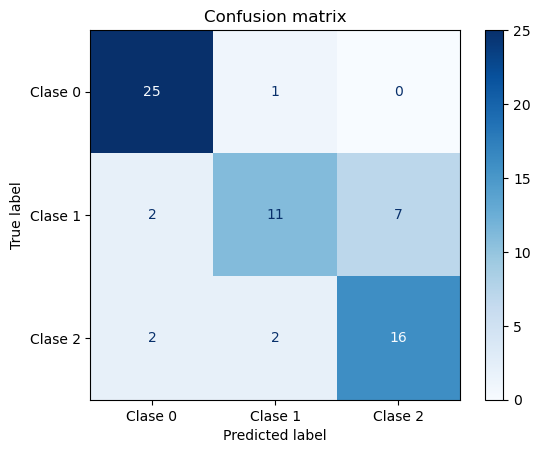

Evaluando modelo B-A2 Bilateral


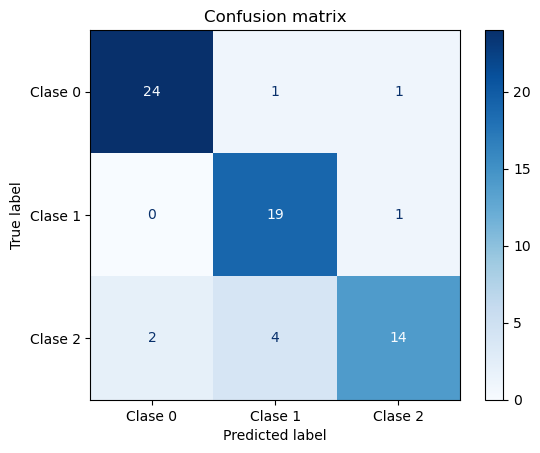

Evaluando modelo B-A2 Canny


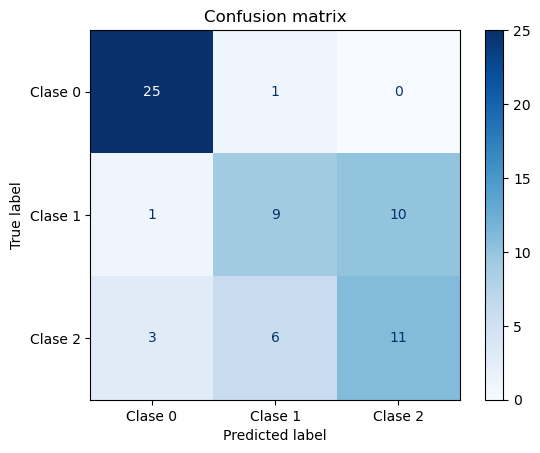

In [22]:
print("Evaluando modelo B-A2 Raw")
y_true_r, y_pred_r = get_predictions(model=model_b_a2_r, data_loader=test_loader_r)
plot_confusion_matrix(y_true_r, y_pred_r, class_names=['Clase 0', 'Clase 1', 'Clase 2'])

print("Evaluando modelo B-A2 Bilateral")
y_true_b, y_pred_b = get_predictions(model=model_b_a2_b, data_loader=test_loader_b)
plot_confusion_matrix(y_true_b, y_pred_b, class_names=['Clase 0', 'Clase 1', 'Clase 2'])

print("Evaluando modelo B-A2 Canny")
y_true_c, y_pred_c = get_predictions(model=model_b_a2_c, data_loader=test_loader_c)
plot_confusion_matrix(y_true_c, y_pred_c, class_names=['Clase 0', 'Clase 1', 'Clase 2'])

## 2.3 Arquitectura 3

### 2.3.1 Definición

In [23]:
class CNN3(nn.Module):
    def __init__(self):
        super(CNN3, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.inception1 = self.InceptionBlock(in_channels=32) # -> 128
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        
        self.fc1 = nn.Linear(in_features=(512 * 8 * 8), out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=3)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(HYPERPARAMETERS["dropout_rate"])

    class InceptionBlock(nn.Module):
        def __init__(self, in_channels):
            super(CNN3.InceptionBlock, self).__init__()
            self.branch1x1 = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=1)

            self.branch3x3_1 = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=1)
            self.branch3x3_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)

            self.branch5x5_1 = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=1)
            self.branch5x5_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, padding=2)

            self.branch_pool = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=1)

        def forward(self, x):
            branch1 = self.branch1x1(x)

            branch2 = self.branch3x3_1(x)
            branch2 = self.branch3x3_2(branch2)

            branch3 = self.branch5x5_1(x)
            branch3 = self.branch5x5_2(branch3)

            branch4 = F.max_pool2d(x, kernel_size=3, stride=1, padding=1)
            branch4 = self.branch_pool(branch4)

            outputs = [branch1, branch2, branch3, branch4]
            return torch.cat(outputs, 1) # (32 + 32 + 32 + 32 = 128)

    def forward(self, x):
        # Etapa 1
        x = self.pool(F.relu(self.conv1(x)))    # [32, 1, 128, 128] -conv-> [32, 32, 128, 128] -ReLu-> same -pooling-> [32, 32, 64, 64]
        x = self.pool(self.inception1(x))       # [32, 32, 64, 64] -incep-> [32, 128, 64, 64] -pooling-> [32, 128, 32, 32]
        x = self.pool(F.relu(self.conv2(x)))    # [32, 128, 32, 32] -conv-> [32, 256, 32, 32] -ReLu-> same -pooling-> [32, 256, 16, 16]
        x = self.pool(F.relu(self.conv3(x)))    # [32, 256, 16, 16] -conv-> [32, 512, 16, 16] -ReLu-> same -pooling-> [32, 512, 8, 8]
        # Etapa 2
        x = x.view(-1, 512 * 8 * 8)             # [32, 512, 8, 8] -view-> [32, 512 * 8 * 8]
        # Etapa 3
        x = F.relu(self.fc1(x))                 # [32, 512 * 8 * 8] -fc-> [32, 64]
        x = self.dropout(x)                     # Aplicar Dropout
        x = self.fc2(x)                         # [32, 64] -fc-> [32, 3]
        return x

#### Justificación de la arquitectura B-A3

La arquitectura CNN3 propuesta combina eficiencia computacional con técnicas avanzadas como el bloque Inception para capturar características a múltiples escalas, optimizando el procesamiento de imágenes para la clasificación en tres clases. A continuación, se describe y justifica cada componente clave de la red.

##### 1. **Capas convolucionales (Conv2D)**
   - **Capas progresivas de convolución**: Esta arquitectura emplea tres capas convolucionales principales, aumentando el número de filtros a través de las capas (32, 256, 512). Esta progresión permite a la red captar patrones cada vez más complejos a medida que la imagen pasa por cada etapa de convolución.
   - **Kernel de 3x3 con padding**: El tamaño del kernel es 3x3, una opción eficiente para detectar patrones locales en imágenes, manteniendo el balance entre precisión y costo computacional.

##### 2. **Bloque Inception**
   - **Representación en múltiples escalas**: La inclusión del bloque Inception después de la primera capa convolucional permite la captura de características en diversas escalas mediante la combinación de diferentes tamaños de kernel (1x1, 3x3, 5x5). Esto enriquece la capacidad de la red para comprender variaciones espaciales complejas en la imagen.
   - **Convolución 1x1 para reducción de dimensionalidad**: El uso de convoluciones de 1x1 reduce el número de canales en los bloques de mayor tamaño, ayudando a optimizar el procesamiento sin sacrificar información clave.

##### 3. **Max Pooling**
   - **Reducción espacial y de complejidad**: Se aplica Max Pooling después de cada convolución y después del bloque Inception, con un kernel de 2x2. Esto disminuye las dimensiones espaciales, lo que reduce la complejidad del modelo y el riesgo de sobreajuste.
   - **Conservación de características importantes**: Al seleccionar el valor máximo en cada región de la imagen, Max Pooling preserva las características más destacadas y descarta datos redundantes.

##### 4. **Capas completamente conectadas (Fully Connected)**
   - **Compresión de la representación**: La salida de la última capa convolucional se convierte en un vector y se pasa por la capa `fc1` de 64 neuronas, lo que permite una representación compacta adecuada para la clasificación final.
   - **Clasificación en 3 clases**: La capa `fc2` genera una salida de 3 neuronas, que corresponde a las tres clases de este problema.

##### 5. **Dropout**
   - **Regularización del modelo**: Dropout se aplica en la capa `fc1` durante el entrenamiento, desactivando aleatoriamente algunas neuronas. Esto mejora la robustez del modelo al evitar la dependencia en conexiones específicas, ayudando a la red a generalizar mejor.

##### 6. **Transformación de `x` a través de la red**
El tensor de entrada `x` sigue una serie de transformaciones a medida que pasa por las capas de la red. A continuación se detalla este flujo:

**x** = `[32, 1, 128, 128]`  
1. `[32, 1, 128, 128]` → **Conv1** → `[32, 32, 128, 128]` → **ReLU** → `[32, 32, 128, 128]` → **MaxPool** → `[32, 32, 64, 64]`  
2. `[32, 32, 64, 64]` → **Inception1** → `[32, 128, 64, 64]` → **MaxPool** → `[32, 128, 32, 32]`  
3. `[32, 128, 32, 32]` → **Conv2** → `[32, 256, 32, 32]` → **ReLU** → `[32, 256, 32, 32]` → **MaxPool** → `[32, 256, 16, 16]`  
4. `[32, 256, 16, 16]` → **Conv3** → `[32, 512, 16, 16]` → **ReLU** → `[32, 512, 16, 16]` → **MaxPool** → `[32, 512, 8, 8]`  
5. `[32, 512, 8, 8]` → **View** → `[32, 512 * 8 * 8]` → **Fully Connected (fc1)** → `[32, 64]`  
6. `[32, 64]` → **Dropout** → **Fully Connected (fc2)** → `[32, 3]`  

### 2.3.2 Creación de los modelos B-A3 (Raw, Bilateral y Canny)

In [24]:
model_b_a3_r = CNN3()  # Modelo para datos crudos
model_b_a3_b = CNN3()  # Modelo para datos con filtro bilateral
model_b_a3_c = CNN3()  # Modelo para datos con filtro Canny

### 2.3.3 Viusalización del modelo B-A3

In [25]:
x = torch.randn(1, 1, 128, 128)  # Tensor de ejemplo
y = model_b_a3_r(x)

dot = make_dot(y, params=dict(list(model_b_a3_r.named_parameters())))
dot.attr(dpi='300')
file_name = 'model_b_a3_graph'
directory = os.path.join(VISUALIZATION_DIR, MODEL_B_GRAPHS_DIR)
dot.render(filename=file_name, directory=directory, format='png')

'visualization\\Model_B_graphs\\model_b_a3_graph.png'

### 2.3.4 Entrenamiento de los modelos B-A3

In [26]:
make_wandb_project(project_name="project_b_a3_r", model_name="model_b_a3_r", hyperparameters=HYPERPARAMETERS,
                   model=model_b_a3_r, print_msg="Training model B-A3 Raw", data_loader=train_sub_loader_r)

make_wandb_project(project_name="project_b_a3_b", model_name="model_b_a3_b", hyperparameters=HYPERPARAMETERS,
                   model=model_b_a3_b, print_msg="Training model B-A3 Bilateral", data_loader=train_sub_loader_b)

make_wandb_project(project_name="project_b_a3_c", model_name="model_b_a3_c", hyperparameters=HYPERPARAMETERS,
                   model=model_b_a3_c, print_msg="Training model B-A3 Canny", data_loader=train_sub_loader_c)

Training model B-A3 Raw


c:\Users\aleja\.conda\envs\env_IC6200_AI_P2_pytorch\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/20], Loss: 1.1302, Accuracy: 42.00%, Learning Rate: 0.001000
Epoch [2/20], Loss: 1.0353, Accuracy: 58.00%, Learning Rate: 0.001000
Epoch [3/20], Loss: 1.0030, Accuracy: 56.00%, Learning Rate: 0.001000
Epoch [4/20], Loss: 0.9288, Accuracy: 58.00%, Learning Rate: 0.001000
Epoch [5/20], Loss: 0.8591, Accuracy: 66.00%, Learning Rate: 0.001000
Epoch [6/20], Loss: 0.7043, Accuracy: 60.00%, Learning Rate: 0.001000
Epoch [7/20], Loss: 0.6998, Accuracy: 68.00%, Learning Rate: 0.001000
Epoch [8/20], Loss: 0.5742, Accuracy: 80.00%, Learning Rate: 0.001000
Epoch [9/20], Loss: 0.5304, Accuracy: 80.00%, Learning Rate: 0.001000
Epoch [10/20], Loss: 0.4124, Accuracy: 76.00%, Learning Rate: 0.001000
Epoch [11/20], Loss: 0.4396, Accuracy: 84.00%, Learning Rate: 0.001000
Epoch [12/20], Loss: 0.6773, Accuracy: 78.00%, Learning Rate: 0.001000
Epoch [13/20], Loss: 0.4873, Accuracy: 88.00%, Learning Rate: 0.001000
Epoch [14/20], Loss: 0.6503, Accuracy: 76.00%, Learning Rate: 0.000500
Epoch [15/20], 

accuracy,▁▃▃▃▅▄▅▇▇▆▇▆█▆▆▇▆▇▇▇
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▇▇▆▆▄▄▃▃▂▂▄▂▄▃▁▃▂▁▁
accuracy,80
epoch,19
loss,0.35677
model,CNN3( (conv1): Con...


Training model B-A3 Bilateral


c:\Users\aleja\.conda\envs\env_IC6200_AI_P2_pytorch\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/20], Loss: 1.2791, Accuracy: 48.00%, Learning Rate: 0.001000
Epoch [2/20], Loss: 1.0986, Accuracy: 32.00%, Learning Rate: 0.001000
Epoch [3/20], Loss: 1.0637, Accuracy: 44.00%, Learning Rate: 0.001000
Epoch [4/20], Loss: 1.0967, Accuracy: 48.00%, Learning Rate: 0.001000
Epoch [5/20], Loss: 1.0705, Accuracy: 48.00%, Learning Rate: 0.001000
Epoch [6/20], Loss: 1.0564, Accuracy: 48.00%, Learning Rate: 0.001000
Epoch [7/20], Loss: 1.0496, Accuracy: 48.00%, Learning Rate: 0.001000
Epoch [8/20], Loss: 0.9718, Accuracy: 50.00%, Learning Rate: 0.001000
Epoch [9/20], Loss: 0.9503, Accuracy: 46.00%, Learning Rate: 0.001000
Epoch [10/20], Loss: 0.9042, Accuracy: 46.00%, Learning Rate: 0.001000
Epoch [11/20], Loss: 0.7942, Accuracy: 66.00%, Learning Rate: 0.001000
Epoch [12/20], Loss: 0.8084, Accuracy: 62.00%, Learning Rate: 0.001000
Epoch [13/20], Loss: 0.6589, Accuracy: 70.00%, Learning Rate: 0.001000
Epoch [14/20], Loss: 0.8161, Accuracy: 72.00%, Learning Rate: 0.001000
Epoch [15/20], 

accuracy,▃▁▃▃▃▃▃▄▃▃▆▅▆▇▇█▇▇▇█
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▇▆▇▆▆▆▆▅▅▄▄▃▄▃▂▄▂▂▁
accuracy,82
epoch,19
loss,0.41369
model,CNN3( (conv1): Con...


Training model B-A3 Canny


c:\Users\aleja\.conda\envs\env_IC6200_AI_P2_pytorch\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/20], Loss: 1.0830, Accuracy: 38.00%, Learning Rate: 0.001000
Epoch [2/20], Loss: 1.1470, Accuracy: 34.00%, Learning Rate: 0.001000
Epoch [3/20], Loss: 1.0917, Accuracy: 46.00%, Learning Rate: 0.001000
Epoch [4/20], Loss: 1.0274, Accuracy: 56.00%, Learning Rate: 0.001000
Epoch [5/20], Loss: 0.8878, Accuracy: 52.00%, Learning Rate: 0.001000
Epoch [6/20], Loss: 0.7840, Accuracy: 56.00%, Learning Rate: 0.001000
Epoch [7/20], Loss: 0.7760, Accuracy: 66.00%, Learning Rate: 0.001000
Epoch [8/20], Loss: 0.6697, Accuracy: 70.00%, Learning Rate: 0.001000
Epoch [9/20], Loss: 0.5664, Accuracy: 88.00%, Learning Rate: 0.001000
Epoch [10/20], Loss: 0.6027, Accuracy: 72.00%, Learning Rate: 0.001000
Epoch [11/20], Loss: 0.6207, Accuracy: 70.00%, Learning Rate: 0.001000
Epoch [12/20], Loss: 0.5932, Accuracy: 74.00%, Learning Rate: 0.001000
Epoch [13/20], Loss: 0.5482, Accuracy: 82.00%, Learning Rate: 0.000500
Epoch [14/20], Loss: 0.6061, Accuracy: 76.00%, Learning Rate: 0.000500
Epoch [15/20], 

accuracy,▂▁▃▄▃▄▅▆█▆▆▆▇▆▆▆▆▆▆▇
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,▇█▇▇▅▄▄▃▂▂▂▂▂▂▃▂▁▂▃▁
accuracy,80
epoch,19
loss,0.4778
model,CNN3( (conv1): Con...


### 2.3.5 Evaluación de los modelos B-A3

In [27]:
print("Evaluating model B-A3 Raw")
evaluate_model(model=model_b_a3_r, test_data_loader=test_loader_r)
print()

print("Evaluating model B-A3 Bilateral")
evaluate_model(model=model_b_a3_b, test_data_loader=test_loader_b)
print()

print("Evaluating model B-A3 Canny")
evaluate_model(model=model_b_a3_c, test_data_loader=test_loader_c)
print()

Evaluating model B-A3 Raw
Accuracy of the model on the test images: 62.12%

Evaluating model B-A3 Bilateral
Accuracy of the model on the test images: 69.70%

Evaluating model B-A3 Canny
Accuracy of the model on the test images: 57.58%



### 2.3.6 Matriz de confusión de los modelos B-A3

Evaluando modelo B-A3 Raw


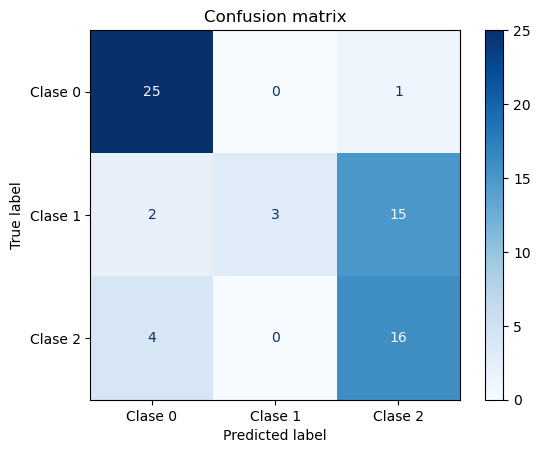

Evaluando modelo B-A3 Bilateral


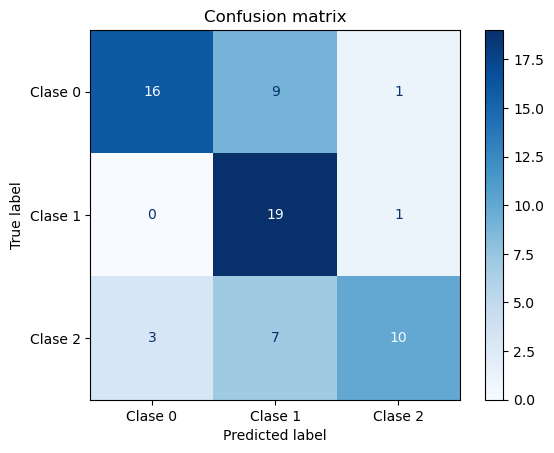

Evaluando modelo B-A3 Canny


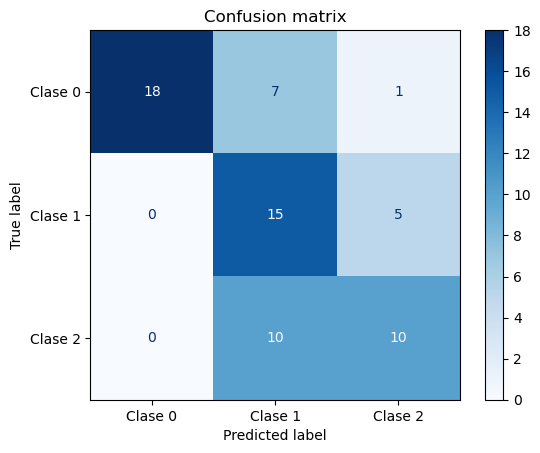

In [28]:
print("Evaluando modelo B-A3 Raw")
y_true_r, y_pred_r = get_predictions(model=model_b_a3_r, data_loader=test_loader_r)
plot_confusion_matrix(y_true_r, y_pred_r, class_names=['Clase 0', 'Clase 1', 'Clase 2'])

print("Evaluando modelo B-A3 Bilateral")
y_true_b, y_pred_b = get_predictions(model=model_b_a3_b, data_loader=test_loader_b)
plot_confusion_matrix(y_true_b, y_pred_b, class_names=['Clase 0', 'Clase 1', 'Clase 2'])

print("Evaluando modelo B-A3 Canny")
y_true_c, y_pred_c = get_predictions(model=model_b_a3_c, data_loader=test_loader_c)
plot_confusion_matrix(y_true_c, y_pred_c, class_names=['Clase 0', 'Clase 1', 'Clase 2'])

# 3. Análisis

## 1. **CNN1**: 
   - Esta red comienza con una capa convolucional que tiene 32 filtros, seguida de un bloque Inception. El bloque Inception toma la entrada de 32 canales y la expande a 128 canales combinando varias convoluciones (1x1, 3x3, 5x5) y una operación de pooling.
   - Luego, tiene una segunda capa convolucional de 128 canales. 
   - Después del procesamiento convolucional, los datos se transforman mediante capas totalmente conectadas (fully connected), comenzando con una capa de 64 neuronas y finalizando con la capa de salida que tiene 3 neuronas, lo que indica que se está trabajando con un problema de clasificación de tres clases.
   - Las dimensiones de las imágenes se reducen progresivamente por medio de operaciones de "pooling" y "view", hasta que los datos son transformados para pasar por las capas fully connected.

### **Pros**:
  - Arquitectura simple y menos profunda, lo que la hace más rápida de entrenar.
  - Menor riesgo de sobreajuste, ya que tiene menos parámetros que las otras redes.
  - Menor consumo de recursos computacionales (memoria y tiempo de entrenamiento).
### **Contras**:
  - Menor capacidad para aprender características complejas, lo que puede limitar su rendimiento en problemas más difíciles.
  - Menos filtros y capas pueden hacerla menos precisa en tareas de clasificación más complejas.


## 2. **CNN2**:
   - En este modelo, la arquitectura es similar a CNN1, pero incluye una tercera capa convolucional adicional. Después de la segunda capa convolucional con 128 filtros, CNN2 aplica una tercera convolución que incrementa los canales a 256.
   - La primera parte de la red sigue siendo casi idéntica: una capa convolucional, un bloque Inception y una segunda convolución. Sin embargo, la tercera convolución aumenta la capacidad del modelo para extraer características más complejas.
   - Al final, la red transforma los datos con una capa fully connected de 64 neuronas, seguida de la capa de salida de 3 neuronas.

### **Pros**:
  - Mayor capacidad que CNN1 gracias a la adición de una tercera capa convolucional con más filtros.
  - Puede aprender características más complejas, lo que mejora su desempeño en problemas más difíciles.
  - Aumenta la complejidad sin ser excesivamente pesada en términos de cómputo.
### **Contras**:
  - Mayor riesgo de sobreajuste comparado con CNN1, ya que tiene más parámetros.
  - Consume más recursos (memoria y tiempo de entrenamiento) que CNN1.


## 3. **CNN3**:
   - Este modelo es el más profundo de los tres. Tras la capa convolucional inicial y el bloque Inception, tiene una segunda convolución que aumenta los canales a 256 (similar a CNN2), pero además, añade una tercera capa convolucional que incrementa los canales a 512.
   - El tamaño de las características se reduce progresivamente con cada operación de "pooling", y después de la tercera convolución, las dimensiones son mucho menores (8x8), lo que implica que CNN3 está preparada para aprender características más abstractas.
   - Finalmente, la red tiene las capas fully connected y de salida, similares a CNN2, pero con una mayor cantidad de información procesada en las etapas previas.

### **Pros**:
  - La arquitectura más profunda y con más filtros la hace más poderosa para capturar características abstractas y complejas.
  - Potencialmente mejor desempeño en tareas con patrones complicados o grandes cantidades de datos.
### **Contras**:
  - Alto riesgo de sobreajuste si no se cuenta con suficientes datos o técnicas de regularización.
  - Mayor demanda de recursos computacionales, con tiempos de entrenamiento más largos y mayor uso de memoria.
  - Puede ser innecesaria para tareas simples, donde una red menos profunda sería más eficiente.


## 3.1 Selección de la arquitectura

La arquitectura CNN2 fue seleccionada como la mejor opción, ya que además de ser la que mejores resultados obtuvo (accuracy), también combina una capacidad intermedia para aprender características complejas con un ciste computacional manejable.